# Семинар "Свёрточные нейронные сети"

# Cвёрточные нейронные сети

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL


def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    
def show_grayscale_image(image, figsize=(16, 9)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [2]:
import torch
import torchvision

In [3]:
layer = torch.nn.Conv2d(1, 1, kernel_size=3)

In [4]:
layer.weight

Parameter containing:
tensor([[[[-0.0973, -0.1207, -0.2474],
          [ 0.3109,  0.1988, -0.0101],
          [-0.3243, -0.0907,  0.1358]]]], requires_grad=True)

In [5]:
# вес доступен через .weight.data
layer.weight.data = torch.ones_like(layer.weight.data) 
layer.weight.data /= torch.sum(layer.weight.data)

In [6]:
layer.weight.data

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])

In [7]:
layer.bias.data = torch.zeros_like(layer.bias.data)

In [8]:
layer.eval()

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

In [9]:
input_tensor = torch.arange(9).reshape(1, 1, 3, 3)

In [10]:
input_tensor.shape

torch.Size([1, 1, 3, 3])

In [11]:
input_tensor

tensor([[[[0, 1, 2],
          [3, 4, 5],
          [6, 7, 8]]]])

In [12]:
output_tensor = layer(input_tensor.float())

In [13]:
output_tensor

tensor([[[[4.]]]], grad_fn=<ThnnConv2DBackward>)

## Модификация весов свертки

In [14]:
path = '../data/photos/cat.png'

In [15]:
# читаем изображение
img = cv2.imread(path, 0)

In [22]:
img

array([[48, 37, 33, ..., 27, 25, 24],
       [48, 39, 39, ..., 22, 23, 26],
       [46, 36, 38, ..., 24, 24, 23],
       ...,
       [85, 73, 75, ..., 69, 70, 70],
       [82, 73, 72, ..., 73, 69, 71],
       [86, 76, 78, ..., 69, 66, 73]], dtype=uint8)

In [17]:
img.shape

(600, 1200)

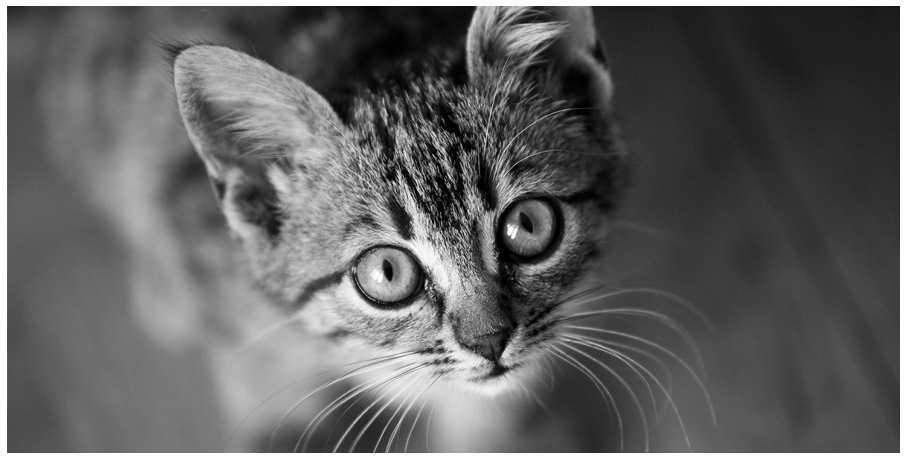

In [18]:
show_grayscale_image(img)

In [19]:
to_tensor = torchvision.transforms.ToTensor()

In [20]:
img_tensor = to_tensor(img)

In [21]:
img_tensor

tensor([[[0.1882, 0.1451, 0.1294,  ..., 0.1059, 0.0980, 0.0941],
         [0.1882, 0.1529, 0.1529,  ..., 0.0863, 0.0902, 0.1020],
         [0.1804, 0.1412, 0.1490,  ..., 0.0941, 0.0941, 0.0902],
         ...,
         [0.3333, 0.2863, 0.2941,  ..., 0.2706, 0.2745, 0.2745],
         [0.3216, 0.2863, 0.2824,  ..., 0.2863, 0.2706, 0.2784],
         [0.3373, 0.2980, 0.3059,  ..., 0.2706, 0.2588, 0.2863]]])

In [23]:
img_tensor.shape

torch.Size([1, 600, 1200])

In [24]:
# делаем так, чтобы нейросеть могла считать изображение

img_tensor = img_tensor.reshape((1, 1, 600, 1200))

In [25]:
assert img_tensor.shape == torch.Size([1, 1, 600, 1200])

## Создадим свертку, которая размоет изображение

In [26]:
kernel_size = 50
layer = torch.nn.Conv2d(1, 1, kernel_size=kernel_size)

In [27]:
# обновите веса так, чтобы получилась свертка, которая размывает изображение

layer.weight.data = torch.ones_like(layer.weight.data) 
layer.weight.data /= torch.sum(layer.weight.data)

In [28]:
layer.weight.data

tensor([[[[0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          ...,
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004],
          [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004]]]])

In [29]:
layer.weight.data.shape

torch.Size([1, 1, 50, 50])

In [30]:
layer.eval()

Conv2d(1, 1, kernel_size=(50, 50), stride=(1, 1))

In [31]:
output_tensor = layer(img_tensor)

In [32]:
output_tensor.shape

torch.Size([1, 1, 551, 1151])

In [33]:
import torchvision.transforms as transforms

# функция, переводящее тензор в PIL-изображение
to_pil_image = transforms.ToPILImage()

In [34]:
output_img = to_pil_image(output_tensor.squeeze(0))

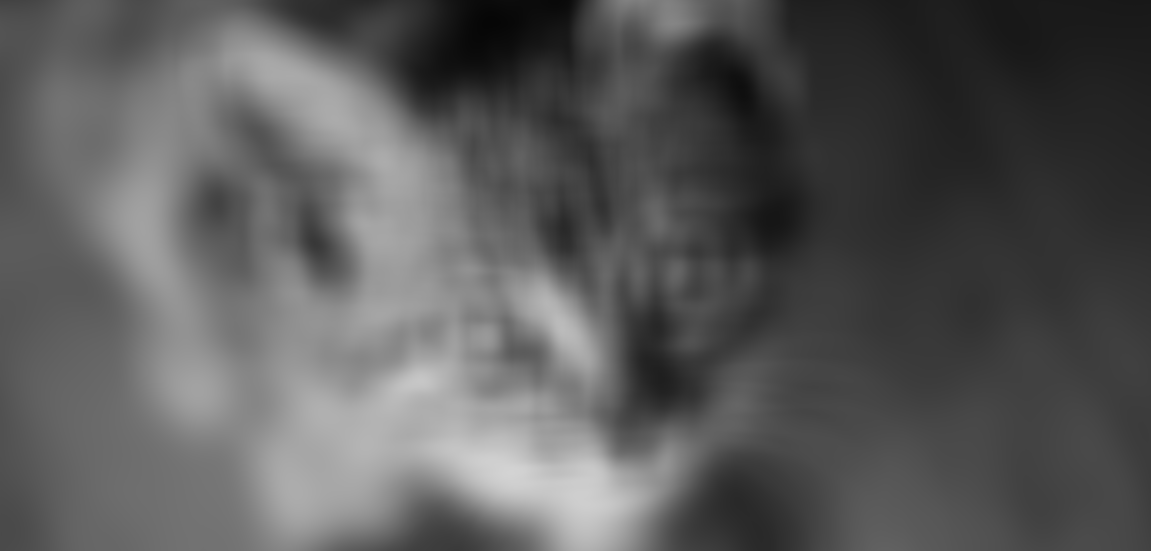

In [35]:
output_img

# Обучие моделей на изображениях

## Данные, преобразования

In [36]:
import torch
import torchvision
import torchvision.transforms as transforms

In [37]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [38]:
batch_size = 4

# dataset задаёт данные
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# dataloader подгружает их
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Отрисовка

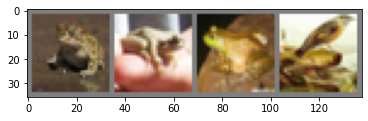

frog  frog  frog  bird


In [39]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    # убрать нормализацию
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# взять случайный батч изображений
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('  '.join('{}'.format(classes[labels[j]]) for j in range(4)))

## Рутина обучения модели

In [40]:
def train_model(net, criterion, optimizer, trainloader, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            
            #дополните код
            
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('Epoch {0}/{1}, iteration {2}, loss: {3:.3f}'.format(epoch + 1, num_epochs, i + 1, 
                                                                          running_loss / 2000))
                running_loss = 0.0
        print()

    print('Finished Training')
    
    return net

## Точность модели на тестовом сете

In [41]:
def all_accuracy(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            # дополните код
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(
        100 * correct / total))

In [42]:
def class_accuracy(net, testloader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of {} : {} %'.format(
            classes[i], 100 * class_correct[i] / class_total[i]))

## Полносвязная сеть для классификации

In [43]:
import torch.nn as nn
import torch.nn.functional as F

# созлайте сеть, состоящую из 3-х полносвязных слоёв (input_size -> 128, 128 -> 32, 32 -> output_size) 
# и испрользовала в качестве активции ReLU

class FeedForwardNet(nn.Module):
    def __init__(self):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        # tip: используйте функцию view для преобразования входа
        x = x.view(-1, 3 * 32 * 32)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
net = FeedForwardNet()

In [44]:
import torch.optim as optim

# дополните код

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [45]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=5)

Epoch 1/5, iteration 2000, loss: 1.948
Epoch 1/5, iteration 4000, loss: 1.730
Epoch 1/5, iteration 6000, loss: 1.676
Epoch 1/5, iteration 8000, loss: 1.634
Epoch 1/5, iteration 10000, loss: 1.596
Epoch 1/5, iteration 12000, loss: 1.568

Epoch 2/5, iteration 2000, loss: 1.493
Epoch 2/5, iteration 4000, loss: 1.502
Epoch 2/5, iteration 6000, loss: 1.466
Epoch 2/5, iteration 8000, loss: 1.491
Epoch 2/5, iteration 10000, loss: 1.476
Epoch 2/5, iteration 12000, loss: 1.439

Epoch 3/5, iteration 2000, loss: 1.393
Epoch 3/5, iteration 4000, loss: 1.405
Epoch 3/5, iteration 6000, loss: 1.376
Epoch 3/5, iteration 8000, loss: 1.392
Epoch 3/5, iteration 10000, loss: 1.388
Epoch 3/5, iteration 12000, loss: 1.388

Epoch 4/5, iteration 2000, loss: 1.317
Epoch 4/5, iteration 4000, loss: 1.347
Epoch 4/5, iteration 6000, loss: 1.325
Epoch 4/5, iteration 8000, loss: 1.311
Epoch 4/5, iteration 10000, loss: 1.354
Epoch 4/5, iteration 12000, loss: 1.324

Epoch 5/5, iteration 2000, loss: 1.269
Epoch 5/5, it

In [46]:
all_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 51.65 %


In [47]:
class_accuracy(net, testloader)

Accuracy of plane : 60.8 %
Accuracy of car : 58.7 %
Accuracy of bird : 34.7 %
Accuracy of cat : 38.6 %
Accuracy of deer : 41.7 %
Accuracy of dog : 41.8 %
Accuracy of frog : 50.3 %
Accuracy of horse : 62.5 %
Accuracy of ship : 69.6 %
Accuracy of truck : 57.8 %


## Свёрточная сеть для классификации

In [48]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [50]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=5)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/5, iteration 2000, loss: 2.152
Epoch 1/5, iteration 4000, loss: 1.806
Epoch 1/5, iteration 6000, loss: 1.640
Epoch 1/5, iteration 8000, loss: 1.531
Epoch 1/5, iteration 10000, loss: 1.484
Epoch 1/5, iteration 12000, loss: 1.435

Epoch 2/5, iteration 2000, loss: 1.391
Epoch 2/5, iteration 4000, loss: 1.343
Epoch 2/5, iteration 6000, loss: 1.319
Epoch 2/5, iteration 8000, loss: 1.312
Epoch 2/5, iteration 10000, loss: 1.300
Epoch 2/5, iteration 12000, loss: 1.266

Epoch 3/5, iteration 2000, loss: 1.191
Epoch 3/5, iteration 4000, loss: 1.201
Epoch 3/5, iteration 6000, loss: 1.197
Epoch 3/5, iteration 8000, loss: 1.204
Epoch 3/5, iteration 10000, loss: 1.172
Epoch 3/5, iteration 12000, loss: 1.182

Epoch 4/5, iteration 2000, loss: 1.079
Epoch 4/5, iteration 4000, loss: 1.097
Epoch 4/5, iteration 6000, loss: 1.115
Epoch 4/5, iteration 8000, loss: 1.083
Epoch 4/5, iteration 10000, loss: 1.110
Epoch 4/5, iteration 12000, loss: 1.115

Epoch 5/5, iteration 2000, loss: 1.036
Epoch 5/5, it

In [51]:
# сохраним сеть
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

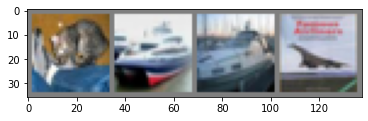

GroundTruth:  cat ship ship plane


In [52]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('{}'.format(classes[labels[j]]) for j in range(batch_size)))

In [53]:
# загрузим сеть
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [54]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('{}'.format(classes[predicted[j]]) for j in range(4)))

Predicted:  cat car ship ship


In [55]:
all_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 59.91 %


In [56]:
class_accuracy(net, testloader)

Accuracy of plane : 55.5 %
Accuracy of car : 73.5 %
Accuracy of bird : 49.1 %
Accuracy of cat : 38.6 %
Accuracy of deer : 66.9 %
Accuracy of dog : 48.0 %
Accuracy of frog : 55.5 %
Accuracy of horse : 65.6 %
Accuracy of ship : 84.7 %
Accuracy of truck : 61.7 %
